# Collection Prediction Model
Predict the `collection` ID based on product features from the Rhomberg catalog.

**Dataset:** 11,970 products with 143 unique collection IDs

**Challenge:** Highly imbalanced - 87% of products have no collection assigned

In [12]:
# ============================================================
# CONFIGURATION
# ============================================================

# Data settings
MIN_SAMPLES_PER_COLLECTION = 5  # Only train on collections with at least N samples
INCLUDE_EMPTY_COLLECTIONS = False  # Treat empty collection as a class?
MAX_SAMPLES_PER_COLLECTION = 10  # Limit samples per collection (None = all available)
# Examples: 10 for quick test, 50 for development, None for full dataset

# Model settings
USE_IMAGES = True  # Use images + text (True) or text only (False)
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 0.0001

# Image source (if you have local access to spark images)
SPARK_IMAGE_PATH = "/mnt/img/jpeg/detailbilder"  # Change this if mounted elsewhere
IMAGE_SIZE = "200"  # Use 200px images (most available)

# Paths
CSV_PATH = "/project/data/feed_a62656-2_de.csv"
OUTPUT_DIR = "/project/data/collection_images"
MODEL_DIR = "/project/models"

print("✓ Configuration loaded")
print(f"  Min samples per collection: {MIN_SAMPLES_PER_COLLECTION}")
print(f"  Max samples per collection: {MAX_SAMPLES_PER_COLLECTION if MAX_SAMPLES_PER_COLLECTION else 'ALL'}")
print(f"  Include empty collections: {INCLUDE_EMPTY_COLLECTIONS}")
print(f"  Using images: {USE_IMAGES}")
print(f"  Image size: {IMAGE_SIZE}px")
print(f"  Spark images: {SPARK_IMAGE_PATH if SPARK_IMAGE_PATH else 'HTTP download only'}")

✓ Configuration loaded
  Min samples per collection: 5
  Max samples per collection: 10
  Include empty collections: False
  Using images: True
  Image size: 200px
  Spark images: /mnt/img/jpeg/detailbilder


In [13]:
# ============================================================
# IMPORTS
# ============================================================

import os
import sys
import shutil
from pathlib import Path
from io import BytesIO
import pandas as pd
import numpy as np
import requests
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from collections import Counter

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision import models

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✓ Using device: {device}")

✓ Using device: cpu


Total products: 11,969

Collection Statistics:
  Empty collections: 10,448 (87.3%)
  Unique collections: 146
  Top 5 collections: {28697.0: 116, 28724.0: 59, 28713.0: 27, 28728.0: 26, 28835.0: 25}
  Collections with ≥5 samples: 117

Limiting to 10 samples per collection...

Filtered dataset: 966 products in 117 collections
  Number of classes: 117


/tmp/ipykernel_28361/1850730222.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('collection', group_keys=False).apply(


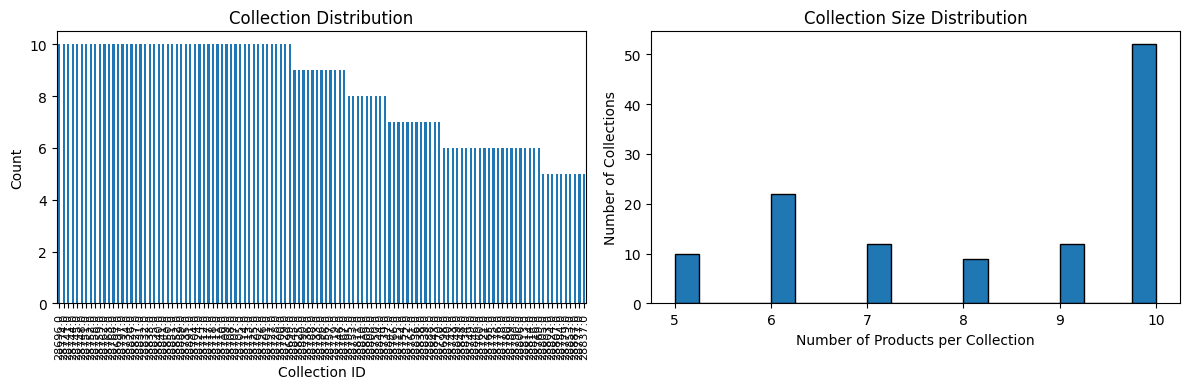

,id,title,link,price,image_link,brand,mpn,gender,age_group,product_type,google_product_category,material,color,item_group_id,collection,collection_encoded
0,347794,Rhomberg Mädchen Ohrringe 925 Delfine,https://www.rhomberg.de/products/ohrringe-925-...,39.00 EUR,https://api.rhomberg.net/static/max/347794.jpg,Rhomberg,347794,female,kids,Ohrschmuck > Ohrhänger,194,Silber,weiss,NaN,28696.0,0
1,586238,Rhomberg Mädchen Ohrhänger Silber Zirkonia lil...,https://www.rhomberg.de/products/ohrhaenger-si...,69.00 EUR,https://api.rhomberg.net/static/max/586238.jpg,Rhomberg,586238,female,kids,Ohrschmuck > Ohrhänger,194,Silber,weiss,NaN,28696.0,0
2,584260,Rhomberg Mädchen Ohrhänger Silber synth. Aquam...,https://www.rhomberg.de/products/ohrhaenger-si...,69.00 EUR,https://api.rhomberg.net/static/max/584260.jpg,Rhomberg,584260,female,kids,Ohrschmuck > Ohrhänger,194,Silber,weiss,NaN,28696.0,0
3,544787,Rhomberg Mädchen Ohrhänger Silber rhodiniert P...,https://www.rhomberg.de/products/ohrhaenger-si...,59.00 EUR,https://api.rhomberg.net/static/max/544787.jpg,Rhomberg,544787,female,kids,Ohrschmuck > Ohrhänger,194,Silber,weiss,NaN,28696.0,0
4,579751,Rhomberg Mädchen Ohrhänger Silber Zirkonia hel...,https://www.rhomberg.de/products/ohrhaenger-si...,49.00 EUR,https://api.rhomberg.net/static/max/579751.jpg,Rhomberg,579751,female,kids,Ohrschmuck > Ohrhänger,194,Silber,weiss,NaN,28696.0,0


In [15]:
# ============================================================
# LOAD AND ANALYZE DATA
# ============================================================

# Load CSV
df = pd.read_csv(CSV_PATH, sep='\t', low_memory=False)
print(f"Total products: {len(df):,}")

# Select relevant columns
columns = ['id', 'title', 'link', 'price', 'image_link', 'brand', 'mpn', 
           'gender', 'age_group', 'product_type', 'google_product_category',
           'material', 'color', 'item_group_id', 'collection']
df = df[columns].copy()

# Analyze collection distribution
print(f"\nCollection Statistics:")
print(f"  Empty collections: {df['collection'].isna().sum():,} ({df['collection'].isna().sum()/len(df)*100:.1f}%)")
print(f"  Unique collections: {df['collection'].nunique()}")

collection_counts = df['collection'].value_counts()
print(f"  Top 5 collections: {collection_counts.head().to_dict()}")
print(f"  Collections with ≥{MIN_SAMPLES_PER_COLLECTION} samples: {(collection_counts >= MIN_SAMPLES_PER_COLLECTION).sum()}")

# Filter to collections with enough samples
if INCLUDE_EMPTY_COLLECTIONS:
    df['collection'] = df['collection'].fillna('EMPTY')
    valid_collections = collection_counts[collection_counts >= MIN_SAMPLES_PER_COLLECTION].index.tolist() + ['EMPTY']
else:
    # Remove rows without collection
    df = df[df['collection'].notna()].copy()
    valid_collections = collection_counts[collection_counts >= MIN_SAMPLES_PER_COLLECTION].index.tolist()

df = df[df['collection'].isin(valid_collections)].copy()

# Apply max samples per collection if specified
if MAX_SAMPLES_PER_COLLECTION:
    print(f"\nLimiting to {MAX_SAMPLES_PER_COLLECTION} samples per collection...")
    df = df.groupby('collection', group_keys=False).apply(
        lambda x: x.sample(n=min(len(x), MAX_SAMPLES_PER_COLLECTION), random_state=42)
    ).reset_index(drop=True)

print(f"\nFiltered dataset: {len(df):,} products in {len(valid_collections)} collections")

# Encode collection labels
label_encoder = LabelEncoder()
df['collection_encoded'] = label_encoder.fit_transform(df['collection'])
num_classes = len(label_encoder.classes_)
print(f"  Number of classes: {num_classes}")

# Display distribution
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
df['collection'].value_counts().plot(kind='bar')
plt.title('Collection Distribution')
plt.xlabel('Collection ID')
plt.ylabel('Count')
plt.xticks(rotation=90, fontsize=8)
plt.tight_layout()

plt.subplot(1, 2, 2)
collection_sizes = df['collection'].value_counts().values
plt.hist(collection_sizes, bins=20, edgecolor='black')
plt.title('Collection Size Distribution')
plt.xlabel('Number of Products per Collection')
plt.ylabel('Number of Collections')
plt.tight_layout()
plt.show()

df.head()

In [16]:
# ============================================================
# DOWNLOAD/COPY IMAGES
# ============================================================

if USE_IMAGES:
    output_dir = Path(OUTPUT_DIR)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # Auto-detect if we're running on spark with local image access
    def is_on_spark():
        """Check if we have local access to spark images."""
        if SPARK_IMAGE_PATH:
            return Path(SPARK_IMAGE_PATH).exists()
        return False
    
    on_spark = is_on_spark()
    print(f"\n{'📁 LOCAL' if on_spark else '🌐 REMOTE'} → {'File copy' if on_spark else 'HTTP download'}")
    print(f"Total products: {len(df):,}")
    
    def copy_local_image(product_id):
        """Copy image from local spark directory."""
        source_path = Path(SPARK_IMAGE_PATH) / IMAGE_SIZE / f"{product_id}.jpg"
        dest_path = output_dir / f"{product_id}.jpg"
        
        if dest_path.exists():
            return True
        
        if source_path.exists():
            try:
                shutil.copy2(source_path, dest_path)
                return True
            except Exception:
                return False
        return False
    
    def download_http_image(image_url, product_id):
        """Download image via HTTP."""
        dest_path = output_dir / f"{product_id}.jpg"
        
        if dest_path.exists():
            return True
        
        try:
            response = requests.get(image_url, timeout=10)
            if response.status_code == 200:
                img = Image.open(BytesIO(response.content))
                img = img.convert('RGB')
                img.save(dest_path, 'JPEG', quality=90)
                return True
        except Exception:
            return False
        return False
    
    # Process images
    success_count = 0
    for idx, row in tqdm(df.iterrows(), total=len(df), desc='Processing images'):
        product_id = row['id']
        
        if on_spark:
            # Use local file copy (fast)
            if copy_local_image(product_id):
                success_count += 1
        else:
            # Use HTTP download (slower but works remotely)
            image_url = row['image_link']
            if download_http_image(image_url, product_id):
                success_count += 1
    
    print(f"✓ Processed {success_count}/{len(df)} images")
    
    # Add image path column
    df['image_path'] = df['id'].apply(lambda x: str(output_dir / f"{x}.jpg"))
    
    # Verify images exist
    df['image_exists'] = df['image_path'].apply(lambda x: Path(x).exists())
    print(f"  Images available: {df['image_exists'].sum()}/{len(df)}")
    
    # Remove rows without images
    df = df[df['image_exists']].copy()
    print(f"\nFinal dataset: {len(df):,} products with images")
else:
    print("\nSkipping image download (USE_IMAGES=False)")


🌐 REMOTE → HTTP download
Total products: 966


Processing images: 100%|██████████| 966/966 [00:01<00:00, 619.25it/s] 

✓ Processed 966/966 images
  Images available: 966/966

Final dataset: 966 products with images


In [17]:
# ============================================================
# TEXT FEATURE EXTRACTION
# ============================================================

# Combine text features
def create_text_features(row):
    """Combine multiple text fields into a single feature string."""
    parts = []
    for col in ['title', 'brand', 'product_type', 'material', 'color', 'gender']:
        val = row.get(col, '')
        if pd.notna(val) and str(val).strip():
            parts.append(str(val).strip())
    return ' '.join(parts)

df['text_features'] = df.apply(create_text_features, axis=1)
print(f"Text features sample: {df['text_features'].iloc[0][:100]}...")

# TF-IDF vectorization
vectorizer = TfidfVectorizer(max_features=500, ngram_range=(1, 2))
text_features_tfidf = vectorizer.fit_transform(df['text_features'])
print(f"\nTF-IDF features: {text_features_tfidf.shape}")
print(f"  Vocabulary size: {len(vectorizer.vocabulary_)}")

Text features sample: Rhomberg Mädchen Ohrringe 925 Delfine Rhomberg Ohrschmuck > Ohrhänger Silber weiss female...

TF-IDF features: (966, 500)
  Vocabulary size: 500


In [18]:
# ============================================================
# TRAIN/VAL SPLIT
# ============================================================

# Split with stratification
train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['collection_encoded'],
    random_state=42
)

print(f"Training set: {len(train_df):,} samples")
print(f"Validation set: {len(val_df):,} samples")
print(f"\nClass distribution in training:")
print(train_df['collection'].value_counts().head(10))

Training set: 772 samples
Validation set: 194 samples

Class distribution in training:
collection
28701.0    8
28763.0    8
28697.0    8
28852.0    8
28774.0    8
28709.0    8
28713.0    8
28705.0    8
28708.0    8
28889.0    8
Name: count, dtype: int64


In [19]:
# ============================================================
# DATASET CLASS
# ============================================================

class CollectionDataset(Dataset):
    """Dataset for collection prediction with images and text."""
    
    def __init__(self, df, text_features, transform=None, use_images=True):
        self.df = df.reset_index(drop=True)
        self.text_features = text_features
        self.transform = transform
        self.use_images = use_images
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Get text features
        text_feat = torch.FloatTensor(self.text_features[idx].toarray().squeeze())
        
        # Get image
        if self.use_images:
            img_path = row['image_path']
            try:
                image = Image.open(img_path).convert('RGB')
                if self.transform:
                    image = self.transform(image)
            except Exception as e:
                # Fallback to black image
                image = torch.zeros(3, IMG_SIZE, IMG_SIZE)
        else:
            image = torch.zeros(3, IMG_SIZE, IMG_SIZE)
        
        # Get label
        label = row['collection_encoded']
        
        return image, text_feat, label

# Data transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Get text features for train/val splits
train_text_feat = text_features_tfidf[train_df.index]
val_text_feat = text_features_tfidf[val_df.index]

# Create datasets
train_dataset = CollectionDataset(train_df, train_text_feat, train_transform, USE_IMAGES)
val_dataset = CollectionDataset(val_df, val_text_feat, val_transform, USE_IMAGES)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"✓ Datasets created")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")

✓ Datasets created
  Train batches: 25
  Val batches: 7


In [20]:
# ============================================================
# MODEL DEFINITION
# ============================================================

class CollectionPredictor(nn.Module):
    """Multi-modal model combining images and text for collection prediction."""
    
    def __init__(self, num_classes, text_feature_dim=500, use_images=True):
        super().__init__()
        self.use_images = use_images
        
        # Image branch (MobileNetV2)
        if use_images:
            mobilenet = models.mobilenet_v2(pretrained=True)
            self.image_features = mobilenet.features
            self.image_pool = nn.AdaptiveAvgPool2d(1)
            image_feat_dim = 1280
        else:
            image_feat_dim = 0
        
        # Text branch
        self.text_fc = nn.Sequential(
            nn.Linear(text_feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        
        # Combined classifier
        combined_dim = image_feat_dim + 128
        self.classifier = nn.Sequential(
            nn.Linear(combined_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, image, text):
        features = []
        
        # Process image
        if self.use_images:
            img_feat = self.image_features(image)
            img_feat = self.image_pool(img_feat)
            img_feat = img_feat.view(img_feat.size(0), -1)
            features.append(img_feat)
        
        # Process text
        text_feat = self.text_fc(text)
        features.append(text_feat)
        
        # Combine and classify
        combined = torch.cat(features, dim=1)
        output = self.classifier(combined)
        return output

# Create model
model = CollectionPredictor(num_classes, text_feature_dim=500, use_images=USE_IMAGES)
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"\n✓ Model created")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /home/workbench/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:01<00:00, 8.64MB/s]


✓ Model created
  Total parameters: 3,267,829
  Trainable parameters: 3,267,829


In [ ]:
# ============================================================
# TRAINING
# ============================================================

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3, verbose=True)

def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for images, text_feat, labels in tqdm(loader, desc='Training'):
        images = images.to(device)
        text_feat = text_feat.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images, text_feat)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    return total_loss / len(loader), 100. * correct / total

def validate(model, loader, criterion):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, text_feat, labels in tqdm(loader, desc='Validating'):
            images = images.to(device)
            text_feat = text_feat.to(device)
            labels = labels.to(device)
            
            outputs = model(images, text_feat)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    return total_loss / len(loader), 100. * correct / total

# Training loop
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0

print(f"\nStarting training for {EPOCHS} epochs...\n")

for epoch in range(EPOCHS):
    print(f"Epoch {epoch+1}/{EPOCHS}")
    
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer)
    val_loss, val_acc = validate(model, val_loader, criterion)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'label_encoder': label_encoder,
            'vectorizer': vectorizer,
        }, f"{MODEL_DIR}/best_collection_model.pth")
        print(f"  ✓ Saved best model (val_acc: {val_acc:.2f}%)")
    
    scheduler.step(val_acc)
    print()

print(f"\n✓ Training complete!")
print(f"  Best validation accuracy: {best_val_acc:.2f}%")

/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Starting training for 30 epochs...

Epoch 1/30


Validating: 100%|██████████| 7/7 [00:14<00:00,  2.10s/it]


  Train Loss: 4.7612 | Train Acc: 1.17%
  Val Loss: 4.7220 | Val Acc: 2.58%
  ✓ Saved best model (val_acc: 2.58%)

Epoch 2/30


Training:  28%|██▊       | 7/25 [00:43<01:53,  6.33s/it]

In [ ]:
# ============================================================
# VISUALIZE RESULTS
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True)

# Accuracy curves
axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o')
axes[1].plot(history['val_acc'], label='Val Accuracy', marker='s')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training and Validation Accuracy')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

print(f"\nFinal Results:")
print(f"  Best Val Accuracy: {best_val_acc:.2f}%")
print(f"  Final Train Accuracy: {history['train_acc'][-1]:.2f}%")
print(f"  Final Val Accuracy: {history['val_acc'][-1]:.2f}%")

In [ ]:
# ============================================================
# SAMPLE PREDICTIONS
# ============================================================

# Load best model
checkpoint = torch.load(f"{MODEL_DIR}/best_collection_model.pth")
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Get some validation samples
sample_indices = np.random.choice(len(val_df), size=min(12, len(val_df)), replace=False)
sample_df = val_df.iloc[sample_indices].reset_index(drop=True)

fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

with torch.no_grad():
    for i, idx in enumerate(sample_indices):
        if i >= 12:
            break
        
        # Get prediction
        image, text_feat, label = val_dataset[idx]
        image = image.unsqueeze(0).to(device)
        text_feat = text_feat.unsqueeze(0).to(device)
        
        output = model(image, text_feat)
        _, predicted = output.max(1)
        
        true_collection = label_encoder.inverse_transform([label.item()])[0]
        pred_collection = label_encoder.inverse_transform([predicted.item()])[0]
        
        # Display
        row = sample_df.iloc[i]
        if USE_IMAGES and Path(row['image_path']).exists():
            img = Image.open(row['image_path'])
            axes[i].imshow(img)
        else:
            axes[i].text(0.5, 0.5, 'No Image', ha='center', va='center')
        
        color = 'green' if true_collection == pred_collection else 'red'
        axes[i].set_title(f"True: {true_collection}\nPred: {pred_collection}", 
                         color=color, fontsize=10)
        axes[i].axis('off')

plt.tight_layout()
plt.show()

# Semi-Supervised Learning: Predict Collections for Unlabeled Products

Now that we have a trained model, let's use it to predict collections for products that don't have a collection assigned yet.

In [ ]:
# ============================================================
# LOAD UNLABELED DATA
# ============================================================

# Load full dataset again
df_full = pd.read_csv(CSV_PATH, sep='\t', low_memory=False)
columns = ['id', 'title', 'link', 'price', 'image_link', 'brand', 'mpn', 
           'gender', 'age_group', 'product_type', 'google_product_category',
           'material', 'color', 'item_group_id', 'collection']
df_full = df_full[columns].copy()

# Split into labeled and unlabeled
df_unlabeled = df_full[df_full['collection'].isna()].copy()
print(f"Total products: {len(df_full):,}")
print(f"Unlabeled products: {len(df_unlabeled):,} ({len(df_unlabeled)/len(df_full)*100:.1f}%)")
print(f"Labeled products used for training: {len(df):,}")

# Create text features for unlabeled data
df_unlabeled['text_features'] = df_unlabeled.apply(create_text_features, axis=1)
unlabeled_text_tfidf = vectorizer.transform(df_unlabeled['text_features'])
print(f"\nUnlabeled text features: {unlabeled_text_tfidf.shape}")

In [ ]:
# ============================================================
# DOWNLOAD IMAGES FOR UNLABELED DATA (Optional - for better predictions)
# ============================================================

DOWNLOAD_UNLABELED_IMAGES = True  # Set to False to skip (faster but text-only predictions)

if USE_IMAGES and DOWNLOAD_UNLABELED_IMAGES:
    print("\nProcessing images for unlabeled data...")
    
    success_count = 0
    for idx, row in tqdm(df_unlabeled.iterrows(), total=len(df_unlabeled), desc='Processing unlabeled images'):
        product_id = row['id']
        
        if on_spark:
            if copy_local_image(product_id):
                success_count += 1
        else:
            image_url = row['image_link']
            if download_http_image(image_url, product_id):
                success_count += 1
    
    print(f"✓ Processed {success_count}/{len(df_unlabeled)} images")
    
    # Add image paths
    df_unlabeled['image_path'] = df_unlabeled['id'].apply(lambda x: str(output_dir / f"{x}.jpg"))
    df_unlabeled['image_exists'] = df_unlabeled['image_path'].apply(lambda x: Path(x).exists())
    print(f"  Images available: {df_unlabeled['image_exists'].sum()}/{len(df_unlabeled)}")
else:
    print("\nSkipping unlabeled image download")
    df_unlabeled['image_path'] = None
    df_unlabeled['image_exists'] = False

In [ ]:
# ============================================================
# PREDICT COLLECTIONS FOR UNLABELED DATA
# ============================================================

# Create dataset for unlabeled data
class UnlabeledDataset(Dataset):
    """Dataset for unlabeled products."""
    
    def __init__(self, df, text_features, transform=None, use_images=True):
        self.df = df.reset_index(drop=True)
        self.text_features = text_features
        self.transform = transform
        self.use_images = use_images
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        
        # Get text features
        text_feat = torch.FloatTensor(self.text_features[idx].toarray().squeeze())
        
        # Get image
        if self.use_images and row['image_exists']:
            img_path = row['image_path']
            try:
                image = Image.open(img_path).convert('RGB')
                if self.transform:
                    image = self.transform(image)
            except Exception:
                image = torch.zeros(3, IMG_SIZE, IMG_SIZE)
        else:
            image = torch.zeros(3, IMG_SIZE, IMG_SIZE)
        
        return image, text_feat, idx

# Create dataloader
unlabeled_dataset = UnlabeledDataset(
    df_unlabeled, 
    unlabeled_text_tfidf, 
    val_transform,  # Use validation transform (no augmentation)
    USE_IMAGES and DOWNLOAD_UNLABELED_IMAGES
)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"✓ Unlabeled dataset created: {len(unlabeled_dataset)} products")

# Make predictions
model.eval()
all_predictions = []
all_probabilities = []

print("\nGenerating predictions...")
with torch.no_grad():
    for images, text_feat, indices in tqdm(unlabeled_loader, desc='Predicting'):
        images = images.to(device)
        text_feat = text_feat.to(device)
        
        outputs = model(images, text_feat)
        probs = torch.softmax(outputs, dim=1)
        
        max_probs, predicted = probs.max(1)
        
        all_predictions.extend(predicted.cpu().numpy())
        all_probabilities.extend(max_probs.cpu().numpy())

# Add predictions to dataframe
df_unlabeled['predicted_collection_encoded'] = all_predictions
df_unlabeled['prediction_confidence'] = all_probabilities
df_unlabeled['predicted_collection'] = label_encoder.inverse_transform(all_predictions)

print(f"✓ Predictions complete!")
print(f"\nPrediction confidence distribution:")
print(f"  Mean confidence: {np.mean(all_probabilities):.3f}")
print(f"  Median confidence: {np.median(all_probabilities):.3f}")
print(f"  High confidence (>0.8): {(np.array(all_probabilities) > 0.8).sum():,} ({(np.array(all_probabilities) > 0.8).sum()/len(all_probabilities)*100:.1f}%)")
print(f"  Medium confidence (0.5-0.8): {((np.array(all_probabilities) >= 0.5) & (np.array(all_probabilities) <= 0.8)).sum():,}")
print(f"  Low confidence (<0.5): {(np.array(all_probabilities) < 0.5).sum():,}")

In [ ]:
# ============================================================
# ANALYZE PREDICTIONS
# ============================================================

# Distribution of predicted collections
print("\nTop 10 predicted collections:")
print(df_unlabeled['predicted_collection'].value_counts().head(10))

# Visualize prediction confidence
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Confidence histogram
axes[0, 0].hist(df_unlabeled['prediction_confidence'], bins=50, edgecolor='black')
axes[0, 0].set_xlabel('Prediction Confidence')
axes[0, 0].set_ylabel('Count')
axes[0, 0].set_title('Distribution of Prediction Confidence')
axes[0, 0].axvline(0.8, color='green', linestyle='--', label='High confidence threshold')
axes[0, 0].axvline(0.5, color='orange', linestyle='--', label='Medium confidence threshold')
axes[0, 0].legend()

# Predicted collections distribution
top_predictions = df_unlabeled['predicted_collection'].value_counts().head(20)
axes[0, 1].bar(range(len(top_predictions)), top_predictions.values)
axes[0, 1].set_xlabel('Collection Rank')
axes[0, 1].set_ylabel('Count')
axes[0, 1].set_title('Top 20 Predicted Collections')
axes[0, 1].set_xticks(range(len(top_predictions)))
axes[0, 1].set_xticklabels([str(x) for x in top_predictions.index], rotation=90, fontsize=8)

# Confidence by predicted collection
collection_confidence = df_unlabeled.groupby('predicted_collection')['prediction_confidence'].mean().sort_values(ascending=False).head(20)
axes[1, 0].barh(range(len(collection_confidence)), collection_confidence.values)
axes[1, 0].set_yticks(range(len(collection_confidence)))
axes[1, 0].set_yticklabels([str(x) for x in collection_confidence.index], fontsize=8)
axes[1, 0].set_xlabel('Mean Confidence')
axes[1, 0].set_title('Average Confidence by Collection')
axes[1, 0].invert_yaxis()

# High vs low confidence comparison
high_conf = df_unlabeled[df_unlabeled['prediction_confidence'] > 0.8]
low_conf = df_unlabeled[df_unlabeled['prediction_confidence'] < 0.5]
axes[1, 1].bar(['High (>0.8)', 'Medium (0.5-0.8)', 'Low (<0.5)'], 
               [(df_unlabeled['prediction_confidence'] > 0.8).sum(),
                ((df_unlabeled['prediction_confidence'] >= 0.5) & (df_unlabeled['prediction_confidence'] <= 0.8)).sum(),
                (df_unlabeled['prediction_confidence'] < 0.5).sum()],
               color=['green', 'orange', 'red'])
axes[1, 1].set_ylabel('Number of Products')
axes[1, 1].set_title('Confidence Level Distribution')

plt.tight_layout()
plt.show()

In [ ]:
# ============================================================
# EXPORT PREDICTIONS
# ============================================================

# Select confidence threshold for export
CONFIDENCE_THRESHOLD = 0.5  # Only export predictions with confidence >= this value

high_confidence_predictions = df_unlabeled[df_unlabeled['prediction_confidence'] >= CONFIDENCE_THRESHOLD].copy()

print(f"\nExporting predictions with confidence >= {CONFIDENCE_THRESHOLD}:")
print(f"  Total predictions: {len(high_confidence_predictions):,} ({len(high_confidence_predictions)/len(df_unlabeled)*100:.1f}%)")

# Create output dataframe
output_df = high_confidence_predictions[['id', 'title', 'predicted_collection', 'prediction_confidence']].copy()
output_df = output_df.sort_values('prediction_confidence', ascending=False)

# Save to CSV
output_path = '/project/data/predicted_collections.csv'
output_df.to_csv(output_path, index=False)
print(f"✓ Saved predictions to: {output_path}")

# Show sample
print(f"\nSample predictions:")
print(output_df.head(20).to_string(index=False))

# Statistics by collection
print(f"\n\nPredictions per collection:")
collection_stats = high_confidence_predictions.groupby('predicted_collection').agg({
    'id': 'count',
    'prediction_confidence': ['mean', 'min', 'max']
}).round(3)
collection_stats.columns = ['Count', 'Mean Conf', 'Min Conf', 'Max Conf']
collection_stats = collection_stats.sort_values('Count', ascending=False)
print(collection_stats.head(20))

## Iterative Semi-Supervised Learning (Optional)

For even better results, you can iteratively refine the model:
1. Add high-confidence predictions to training set
2. Retrain the model with expanded dataset
3. Predict again on remaining unlabeled data
4. Repeat until convergence

This gradually improves the model by using its own confident predictions as additional training data.

In [ ]:
# ============================================================
# ITERATIVE REFINEMENT (OPTIONAL)
# ============================================================

RUN_ITERATIVE_TRAINING = False  # Set to True to enable iterative refinement
REFINEMENT_THRESHOLD = 0.9  # Only add predictions with very high confidence
MAX_ITERATIONS = 3

if RUN_ITERATIVE_TRAINING:
    print("Starting iterative semi-supervised refinement...\n")
    
    # Start with original labeled data
    current_train_df = df.copy()
    iteration_results = []
    
    for iteration in range(MAX_ITERATIONS):
        print(f"=== Iteration {iteration + 1}/{MAX_ITERATIONS} ===")
        
        # Get high-confidence predictions from unlabeled data
        unlabeled_remaining = df_unlabeled[~df_unlabeled['id'].isin(current_train_df['id'])].copy()
        high_conf_new = unlabeled_remaining[
            unlabeled_remaining['prediction_confidence'] >= REFINEMENT_THRESHOLD
        ].copy()
        
        if len(high_conf_new) == 0:
            print("No high-confidence predictions to add. Stopping.")
            break
        
        print(f"Adding {len(high_conf_new)} high-confidence predictions to training set")
        
        # Add to training data
        high_conf_new['collection'] = high_conf_new['predicted_collection']
        high_conf_new['collection_encoded'] = high_conf_new['predicted_collection_encoded']
        current_train_df = pd.concat([current_train_df, high_conf_new], ignore_index=True)
        
        print(f"New training set size: {len(current_train_df):,}")
        
        # Retrain model
        # (Here you would repeat the training process with current_train_df)
        # For now, we'll just track the statistics
        
        iteration_results.append({
            'iteration': iteration + 1,
            'training_samples': len(current_train_df),
            'predictions_added': len(high_conf_new),
            'mean_confidence': high_conf_new['prediction_confidence'].mean()
        })
        
        print(f"  Mean confidence of added samples: {high_conf_new['prediction_confidence'].mean():.3f}")
        print()
    
    # Summary
    print("\n=== Iterative Refinement Summary ===")
    results_df = pd.DataFrame(iteration_results)
    print(results_df.to_string(index=False))
else:
    print("Iterative refinement disabled. Set RUN_ITERATIVE_TRAINING=True to enable.")